In [1]:
import torch
import random
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

torch.manual_seed(1)

In [2]:
!nvidia-smi
MAX_VOCAB_SIZE=64841
data_dir = "../msci-nlp-w22/sentiment/"

Wed Apr  6 18:00:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8    N/A /  N/A |      0MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(torch.cuda.is_available() )
print(device)

True
cuda:0


In [4]:
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

In [5]:
# TEXT = data.Field(tokenize='spacy', include_lengths=True)
# LABEL = data.LabelField()

# train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
# TEXT.build_vocab(train_data, vectors='glove.6B.100d')

# TEXT.vocab.vectors.size()

In [6]:
# Read the Lines in the Training Set
pos_data_lines=get_lines(data_dir+"pos.txt")
neg_data_lines=get_lines(data_dir+"neg.txt")
sentences = []
for txt in pos_data_lines:
    line_data = {}
    line_data["target"]="POSITIVE"
    line_data["text"] = txt
    sentences.append(line_data)
for txt in neg_data_lines:
    line_data = {}
    line_data["target"]="NEGATIVE"
    line_data["text"] = txt
    sentences.append(line_data)

In [7]:
random.shuffle(sentences)
train_samples = sentences[:round(len(sentences)*0.8)]
test_samples = sentences[:round(len(sentences)*0.2)]
random.shuffle(sentences)
val_samples = sentences[:round(len(sentences)*0.2)]

In [8]:
print(type(train_samples[0]["target"]) , type(train_samples[0]["text"]))

<class 'str'> <class 'str'>


In [9]:
# Converting data to df
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(val_samples)

# Data distribution
train_df.target.value_counts()

# Isolating the sentences
train_sentences=train_df["text"].tolist()
test_sentences=test_df["text"].tolist()
val_sentences=val_df["text"].tolist()

In [10]:
# Turning the target Labels into Numeric Data
# We have 5 main labels -> Background, Objective,Methods, Results, Conclusion
# We'll encode them both 1HEC and Simple Numerical

# Tensorflow is incompatible with sparse matrices
one_hot_encoder=OneHotEncoder(sparse=False)
# You should reshape your X to be a 2D array not 1D array. Fitting a model requires requires a 2D array. i.e (n_samples, n_features)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot,val_labels_one_hot,test_labels_one_hot

le=LabelEncoder()
train_labels_encoded=le.fit_transform(train_df["target"])
test_labels_encoded=le.fit_transform(test_df["target"])
val_labels_encoded=le.fit_transform(val_df["target"])

train_labels_onehot = nn.functional.one_hot(torch.from_numpy(train_labels_encoded).to(torch.int64), num_classes=- 1)
val_labels_onehot = nn.functional.one_hot(torch.from_numpy(val_labels_encoded).to(torch.int64), num_classes=- 1)
test_labels_onehot = nn.functional.one_hot(torch.from_numpy(test_labels_encoded).to(torch.int64), num_classes=- 1)


# Retieving classes 
num_classes=len(le.classes_)
class_names=le.classes_
num_classes,class_names

(2, array(['NEGATIVE', 'POSITIVE'], dtype=object))

In [11]:
# Vectorize the text and then create Embeddings

# How long is each sentence on average
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_lens=np.mean(sent_lens)
avg_sent_lens
# sent_lens
#  So we will need Padding and Truncating as the input shapes must be maintained

# Calculate the percentile of length of sentences
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len
# So 95% sentences are in length of 24

# Creating a text Vectorization Layer
# Mapping our text from words to Numbers
# An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. 
# Vocabulary size in the Research Paper is 68000
max_tokens=64841

text_vectorizer=TextVectorization(max_tokens=max_tokens,output_sequence_length=output_seq_len)

# Adapt the Text Vectorizer to the Training Data
# We have to adapt it to only the training data so that val and test data are not seen
# Later it can be fitted to the two latter
text_vectorizer.adapt(train_sentences)

In [12]:
# Finding out how many words are there  in the training vocabulary and which are  most common
# Also text vectorizer works pretty straightforwardly, 1 to most common word, 2 to 2nd most common word and so on
train_vocab=text_vectorizer.get_vocabulary()
# Size of Vocab
print(len(train_vocab))
# 5 Most Common Words in the Vocab
print(train_vocab[:5])
# Least common 5 words in the vocab
print(train_vocab[-5:])

# Get the config of our Text Vectorizer
text_vectorizer.get_config()

64841
['', '[UNK]', 'the', 'i', 'and']
['sugaf', 'suffrage', 'suffocates', 'suffocated', 'sufficientthese']


{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 64841,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 24,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [13]:
token_embed_py = torch.nn.Embedding(num_embeddings=len(train_vocab), embedding_dim=128, padding_idx=0)

In [14]:
# Dataset class for vectorized sentences
class CustomTextDataset(Dataset):
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        return data, label

In [15]:
train_dataset = CustomTextDataset(train_sentences, train_labels_one_hot)
val_dataset = CustomTextDataset(val_sentences, val_labels_one_hot)
test_dataset = CustomTextDataset(test_sentences, test_labels_one_hot)

train_loader = DataLoader(train_dataset, batch_size=28, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=28, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=28, shuffle=True)

# LSTM
https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

In [16]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(train_vocab), 300, padding_idx=0)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 2)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        #packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_input = text_emb
        packed_output, _ = self.lstm(packed_input)
        #output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = packed_output
        
        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out
    
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [17]:
destination_folder = "D:/med_abstracts/models"

# Training Function

def train(model,
          optimizer,
          scheduler,
          criterion = nn.BCELoss(),
          train_loader = train_loader,
          valid_loader = val_loader,
          num_epochs = 5,
          eval_every = len(train_loader) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for data, labels in train_loader:   
            data = text_vectorizer(data).numpy()
            data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)

            output = model(data, output_seq_len)

            loss = criterion(output, labels.to(torch.float32))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            
            # update running values
            running_loss += loss.item()
            global_step += 1

            
            
            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for data, labels in valid_loader:
                        data = text_vectorizer(data).numpy()
                        data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)
                        output = model(data, output_seq_len)

                        loss = criterion(output, labels.to(torch.float32))
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    

num_epochs = 10
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

train(model=model, optimizer=optimizer, scheduler=scheduler, num_epochs=num_epochs)

<ipython-input-17-ac23940a4190>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)
<ipython-input-17-ac23940a4190>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)


Epoch [1/10], Step [11429/228580], Train Loss: 0.4578, Valid Loss: 0.3868
Model saved to ==> D:/med_abstracts/models/model.pt
Model saved to ==> D:/med_abstracts/models/metrics.pt
Epoch [1/10], Step [22858/228580], Train Loss: 0.3924, Valid Loss: 0.3539
Model saved to ==> D:/med_abstracts/models/model.pt
Model saved to ==> D:/med_abstracts/models/metrics.pt
Epoch [2/10], Step [34287/228580], Train Loss: 0.3458, Valid Loss: 0.3226
Model saved to ==> D:/med_abstracts/models/model.pt
Model saved to ==> D:/med_abstracts/models/metrics.pt
Epoch [2/10], Step [45716/228580], Train Loss: 0.3426, Valid Loss: 0.3047
Model saved to ==> D:/med_abstracts/models/model.pt
Model saved to ==> D:/med_abstracts/models/metrics.pt
Epoch [3/10], Step [57145/228580], Train Loss: 0.2943, Valid Loss: 0.2825
Model saved to ==> D:/med_abstracts/models/model.pt
Model saved to ==> D:/med_abstracts/models/metrics.pt
Epoch [3/10], Step [68574/228580], Train Loss: 0.3032, Valid Loss: 0.2687
Model saved to ==> D:/med_

Model loaded from <== D:/med_abstracts/models/metrics.pt


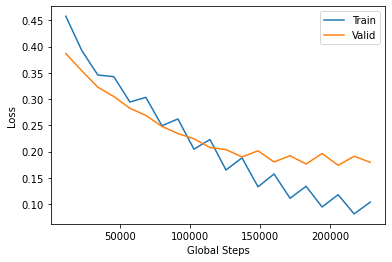

In [18]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== D:/med_abstracts/models/model.pt


<ipython-input-20-031eb765a91b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)


[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0]]
[[1, 0], [1, 0], [1, 0], [0, 1], [1, 0]]
Classification Report:
              precision    recall  f1-score   support

    NEGATIVE     0.9810    0.9739    0.9775     80170
    POSITIVE     0.9740    0.9811    0.9775     79830

   micro avg     0.9775    0.9775    0.9775    160000
   macro avg     0.9775    0.9775    0.9775    160000
weighted avg     0.9775    0.9775    0.9775    160000
 samples avg     0.9775    0.9775    0.9775    160000

[[0.9739304  0.0260696 ]
 [0.01894025 0.98105975]]


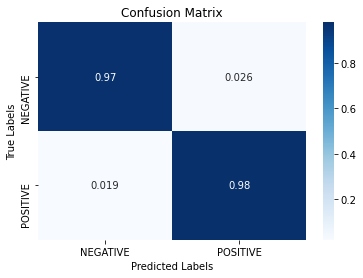

In [20]:
# Evaluation Function
word_labels = np.unique(train_df["target"])
word_labels_short = [word_labels[i] for i in np.arange(len(word_labels))]

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data = text_vectorizer(data).numpy()
            data, labels = torch.tensor(data).to(device), torch.tensor(labels).to(device)
            output = model(data, output_seq_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print(y_true[:5])
    print(y_pred[:5])
    
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[0,1], target_names=word_labels, digits=4))
    
    cm = confusion_matrix(np.array(y_true).argmax(axis=1), np.array(y_pred).argmax(axis=1), labels=[0,1], normalize='true')
    print(cm)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues')

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(word_labels_short)
    ax.yaxis.set_ticklabels(word_labels_short)
    
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_loader)

In [ ]:
l = [module for module in model.modules() if not isinstance(module, nn.Sequential)]
print(l)